# NX-414 - Mini-project

Group members: Kolly Florian, Mikami Sarah, Montlahuc Louise

## Project description
The objectives of the project are:
- Predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach
- Develop the most accurate model for predicting IT neural activity

Specifically, we use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

## Imports

In [1]:
# ALL NECESSARY IMPORTS
from abc import ABC
import inspect
import h5py
import os
import re
import random
import gdown
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR, SequentialLR
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import explained_variance_score, r2_score
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold
from sklearn.calibration import LabelEncoder
from sklearn.neural_network import MLPRegressor
from fvcore.common.registry import Registry
from torchvision.models import resnet50, resnext101_32x8d, convnext_base, resnet18, vit_b_16
from torchvision.models import ResNet50_Weights, ResNeXt101_32X8D_Weights, ConvNeXt_Base_Weights, ResNet18_Weights, ViT_B_16_Weights

## Models interface

For genericity and reusability, we define an interface for all models.

In [2]:
# IModel INTERFACE
class IModel(ABC, nn.Module):
    """
    Abstract base class for a model.
    This class defines the interface that all model classes must implement.
    All models inheriting from this class should have a self.model attribute!
    """
    def __init__(self):
        super().__init__()
        self.PCs = dict()
        self.ACTs = dict()
        self.PCA = dict()
        self.pca_fitted = []

    def forward(self, images):
        return self.model(images)
    
    def get_layers(self, layer_name=None):
        """
        Returns the layers on which to do the linear probing.
        """
        layers = []
        if not layer_name:
            layers_name = [name for name, _ in self.model.named_children()]
            for name in layers_name[-4:-1]:
                module = self.model.get_submodule(name)
                layers.append((name, module))
        else:
            module = self.model.get_submodule(layer_name)
            layers.append((layer_name, module))
        return layers
        
    def get_activations(self, hook_name):
        """
        Returns the activations of the model.
        The hook_name can be 'all' for all activations or 'pca' for 1000 principal components.
        """
        if hook_name == 'all':
            return self.ACTs
        elif hook_name == 'pca':
            return self.PCs
        else:
            raise ValueError("Invalid hook name. Use 'all' or 'pca'.")
        
    def reset_activations(self):
        """
        Resets the activations of the model.
        """
        self.PCs = dict()
        self.ACTs = dict()

    def _get_PCs_hook(self, module, input, output, layer_name):
        print('Layer:', layer_name)
        activations = output.detach().cpu().numpy().reshape(output.shape[0], -1)
        print('Activations shape:', activations.shape)
        if activations.shape[1] > 1000:
            if layer_name in self.pca_fitted:
                pca_features = self.PCA[layer_name].transform(activations)
                print('Principal components shape:', pca_features.shape)
                self.PCs[layer_name] = pca_features
            else:
                pca = PCA(n_components=1000)
                print(pca)
                self.PCA[layer_name] = pca
                pca_features = pca.fit_transform(activations)
                self.pca_fitted.append(layer_name)
                print('Principal components shape:', pca_features.shape)
                self.PCs[layer_name] = pca_features
        else:
            self.PCs[layer_name] = activations
            
    def _get_activations_hook(self, module, input, output, layer_name):
        activations = output.detach().cpu().numpy().reshape(output.shape[0], -1)
        self.ACTs[layer_name] = activations
    
    def register_hook(self, hook_name, finetune, layer_name):
        """
        Registers a hook to the model.
        The hook can be 'all' for all activations or 'pca' for 1000 principal components.
        """
        handles = []
        layers = self.get_layers(layer_name) if finetune else self.get_layers()
            
        for name, layer in layers:
            if hook_name == 'all':
                handle = layer.register_forward_hook(lambda m, i, o, n=name: self._get_activations_hook(m, i, o, n))
            elif hook_name == 'pca':
                handle = layer.register_forward_hook(lambda m, i, o, n=name: self._get_PCs_hook(m, i, o, n))
            handles.append(handle)
        return handles
    
    def change_head(self, layer, num_classes):
        """
        Sets a final head (classification or regression) after the indicated layer.
        """
        return ModifiedModel(self.model, layer, num_classes)

For finetuning models, we create a class that extends our generic model interface ```IModel``` and contains both the original model alongside the modified model. As we are testing multiple models and multiple finetuning methods, our goal is to stay as generic as possible.

In [ ]:
# ModifiedModel class
class ModifiedModel(IModel):
    def __init__(self, base_model, insert_after, num_classes):
        super().__init__()
        self.model = base_model
        self.insert_after = insert_after
        self.num_classes = num_classes

        # Register hook on specified layer
        self._register_hook()

        # Run dummy forward to get shape of features
        dummy_input = torch.randn(1, 3, 224, 224)
        with torch.no_grad():
            _ = self.model(dummy_input)
            features = self.captured_features

        # Process features according to type (ViT vs CNN)
        if features.dim() == 4:  # CNN style: [B, C, H, W]
            features = nn.AdaptiveAvgPool2d((16, 16))(features)
            features = features.reshape(features.size(0), -1)
        elif features.dim() == 3:  # ViT style: [B, N, D]
            features = features[:, 0]  # Use only [CLS] token
        else:
            raise ValueError("Unknown feature shape from intercepted layer")

        in_features = features.shape[1]

        # Define classifier head
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((16, 16)),
            nn.Flatten(),
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, num_classes)
        ) if features.dim() == 4 else  nn.Sequential(
                nn.Linear(in_features, 1024),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, num_classes)
            )
        
    def _register_hook(self):
        def hook_fn(module, input, output):
            self.captured_features = output

        # Traverse and hook the desired layer
        for name, module in self.model.named_modules():
            if name == self.insert_after:
                module.register_forward_hook(hook_fn)
                self.hooked_layer = module
                return
        raise ValueError(f"Layer '{self.insert_after}' not found in model.")

    def _forward_features(self, x):
        for name, module in self.features.named_children():
            if isinstance(module, nn.ModuleList):
                for submodule in module:
                    x = submodule(x)
            else:
                x = module(x)
        return x

    def forward(self, x):
        _ = self.model(x)
        features = self.captured_features

        if features.dim() == 4:  # CNN
            features = nn.AdaptiveAvgPool2d((16, 16))(features)
            features = features.reshape(features.size(0), -1)
        elif features.dim() == 3:  # ViT
            features = features[:, 0]

        return self.fc(features)

    def get_layers(self, layer_name=None):
        return [(self.insert_after, self.hooked_layer)]

We then create a build function that takes a model name and a set of parameters, and returns the corresponding model.

In [4]:
MODEL_REGISTRY = Registry("MODEL")
MODEL_REGISTRY.__doc__ = """
Registry for models.

The registered object will be called with `obj()`.
The call should return a `nn.Module` object.
"""

def accepts_seed(cls):
    init = cls.__init__
    sig = inspect.signature(init)
    return 'seed' in sig.parameters

def make_model(name, seed):
    """
    Builds the video model.
    Args:
        name (string): name of the model to build.
    Returns:
        model (nn.Module): the built model.
    """
    model = MODEL_REGISTRY.get(name)
    if accepts_seed(model):
        model = model(seed)
    else:
        model = model()
    
    return model

## Loading the data

Let's now setup the loading of the data. We start with some utility functions that were given in the project.

In [5]:
### Utils
def download_data(path_to_data):
    if not os.path.exists(path_to_data):
        os.makedirs(os.path.dirname(path_to_data))
    output = "IT_data.h5"
    data_path = os.path.join(path_to_data, output)
    if not os.path.exists(data_path):
        url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
        gdown.download(url, os.path.join(path_to_data, output), quiet=False, fuzzy=True)

def load_it_data(path_to_data):
    """ Load IT data

    Args:
        path_to_data (str): Path to the data

    Returns:
        np.array (x6): Stimulus train/val/test; objects list train/val/test; spikes train/val
    """

    datafile = h5py.File(os.path.join(path_to_data,'IT_data.h5'), 'r')

    stimulus_train = datafile['stimulus_train'][()]
    spikes_train = datafile['spikes_train'][()]
    objects_train = datafile['object_train'][()]
    
    stimulus_val = datafile['stimulus_val'][()]
    spikes_val = datafile['spikes_val'][()]
    objects_val = datafile['object_val'][()]
    
    stimulus_test = datafile['stimulus_test'][()]
    objects_test = datafile['object_test'][()]

    ### Decode back object type to latin
    objects_train = [obj_tmp.decode("latin-1") for obj_tmp in objects_train]
    objects_val = [obj_tmp.decode("latin-1") for obj_tmp in objects_val]
    objects_test = [obj_tmp.decode("latin-1") for obj_tmp in objects_test]

    return stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val

Let's now create a function for retrieving the data we are interested in.

In [6]:
def get_data():
    """Get the data from the IT dataset.

    Returns:
        tuple: tuples (stimulus, objects, spikes) for training and validation sets.
    """
    stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data('src/data/')
    return (stimulus_train, objects_train, spikes_train), (stimulus_val, objects_val, spikes_val)

## Part 1: Linear regression models to predict neural activity from pixels

First, we load the dataset using the functions defined above.

In [ ]:
train_data, val_data = get_data()
stimulus_train, objects_train, spikes_train = train_data
stimulus_val, objects_val, spikes_val = val_data

In the first part of the project, we develop a linear regression model which can predict the neural activity from pixels. We use three different types of linear regression: least-square regression, ridge regression, and ridge regression with high regularization.

In [ ]:
linreg = LinearRegression()
ridge = Ridge(alpha=1.0)
ridge_highreg = Ridge(alpha=100.0)

# Flatten the images into a 2D array (n_stimulus, n_channels * img_size * img_size)
stim_train = stimulus_train.reshape(stimulus_train.shape[0], -1)
scaler = StandardScaler()
stim_train = scaler.fit_transform(stim_train)

linreg.fit(stim_train, spikes_train)
ridge.fit(stim_train, spikes_train)
ridge_highreg.fit(stim_train, spikes_train)

# Evaluate the models on the training data (R^2 score), if too high can indicate overfitting
linreg_score_train = linreg.score(stim_train, spikes_train)
ridge_score_train = ridge.score(stim_train, spikes_train)
ridge_highreg_score_train = ridge_highreg.score(stim_train, spikes_train)

print('Linear regression score on training data: ', linreg_score_train)
print('Ridge regression score on training data: ', ridge_score_train)
print('Ridge regression score with high regularization on training data: ', ridge_highreg_score_train)

stim_val = stimulus_val.reshape(stimulus_val.shape[0], -1)
stim_val = scaler.transform(stim_val)

# Evaluate the models on the validation data (R^2 score)
linreg_score_val = linreg.score(stim_val, spikes_val)
ridge_score_val = ridge.score(stim_val, spikes_val)
ridge_highreg_score_val = ridge_highreg.score(stim_val, spikes_val)

print('Linear regression score on validation data: ', linreg_score_val)
print('Ridge regression score on validation data: ', ridge_score_val)
print('Ridge regression score with high regularization on validation data: ', ridge_highreg_score_val)

/opt/anaconda3/envs/nx-414/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=2.34954e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Linear regression score on training data:  0.38400980830192566
Ridge regression score on training data:  0.9999993443489075
Ridge regression score with high regularization on training data:  0.9983471632003784
Linear regression score on validation data:  -0.04113948345184326
Ridge regression score on validation data:  -0.929978609085083
Ridge regression score with high regularization on validation data:  -0.7975594401359558


Now, we can evaluate the predictions by checking both the correlation and the explained variance for each neuron. We plot the distribution for the explained variance across neurons.

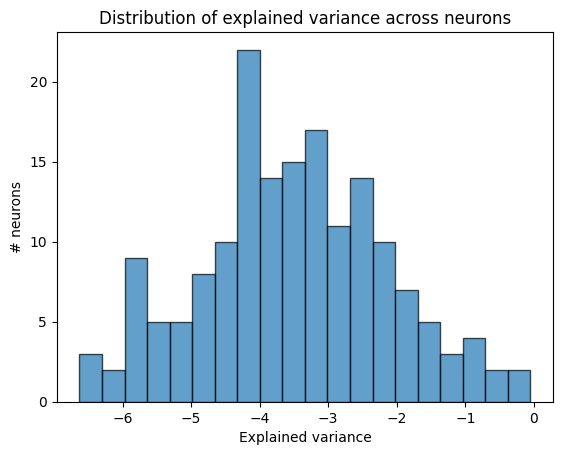

In [49]:
def evaluate_model(model, stimulus, spikes):
    pred = model.predict(stimulus.reshape(stimulus.shape[0], -1))

    correlations = []
    explained_variances = []

    for i in range(spikes.shape[1]):
        # Correlation
        corr, _ = pearsonr(pred[:, i], spikes[:, i])
        correlations.append(corr)
        
        # Explained variance
        ev = explained_variance_score(pred[:, i], spikes[:, i])
        explained_variances.append(ev)

    # Plot distribution of explained variance
    plt.hist(explained_variances, bins=20, edgecolor='k', alpha=0.7)
    plt.xlabel('Explained variance')
    plt.ylabel('# neurons')
    plt.title('Distribution of explained variance across neurons')
    plt.show()

evaluate_model(linreg, stimulus_val, spikes_val)

To improve the performance, we apply Principal Component Analysis (PCA) instead of predicting from pixels. This helps capturing the high dimensional structure of the images. We use the corresponding 1000 PCs.

In [50]:
pca = PCA(n_components=1000)
stim_train_pca = pca.fit_transform(stim_train)
stim_val_pca = pca.transform(stim_val)

linreg = LinearRegression()
ridge = Ridge(alpha=1.0)
ridge_highreg = Ridge(alpha=100.0)

linreg.fit(stim_train_pca, spikes_train)
ridge.fit(stim_train_pca, spikes_train)
ridge_highreg.fit(stim_train_pca, spikes_train)

linreg_score_train = linreg.score(stim_train_pca, spikes_train)
ridge_score_train = ridge.score(stim_train_pca, spikes_train)
ridge_highreg_score_train = ridge_highreg.score(stim_train_pca, spikes_train)

print('Linear regression score on training data: ', linreg_score_train)
print('Ridge regression score on training data: ', ridge_score_train)
print('Ridge (high reg.) regression score on training data: ', ridge_highreg_score_train)

linreg_score_val = linreg.score(stim_val_pca, spikes_val)
ridge_score_val = ridge.score(stim_val_pca, spikes_val)
ridge_highreg_score_val = ridge_highreg.score(stim_val_pca, spikes_val)

print('Linear regression score on validation data: ', linreg_score_val)
print('Ridge regression score on validation data: ', ridge_score_val)
print('Ridge (high reg.) regression score on validation data: ', ridge_highreg_score_val)

Linear regression score on training data:  0.4685114920139313
Ridge regression score on training data:  0.4685114324092865
Ridge (high reg.) regression score on training data:  0.46850675344467163
Linear regression score on validation data:  -0.07858569175004959
Ridge regression score on validation data:  -0.07857196033000946
Ridge (high reg.) regression score on validation data:  -0.07735566794872284


To improve the predictions, we then use a 5-fold cross-validation to find the best parameters for ridge regression between 20 different alpha values. Without PCA:

In [51]:
alphas = np.logspace(2, 10, 20)
ridge = Ridge()

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
splits = list(cv.split(stim_train, objects_train, groups=objects_train))
grid_search = GridSearchCV(ridge, param_grid={'alpha': alphas}, cv=splits, n_jobs=-1)
grid_search.fit(stim_train, spikes_train)

best_alpha = grid_search.best_params_['alpha']
print("Best alpha value:", best_alpha)

best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(stim_train, spikes_train)
ridge_score_train = best_ridge.score(stim_train, spikes_train)
ridge_score_val = best_ridge.score(stim_val, spikes_val)

print("Best Ridge Regression score on training set:", ridge_score_train)
print("Best Ridge Regression score on validation set:", ridge_score_val)

Best alpha value: 615848.2110660254
Best Ridge Regression score on training set: 0.16825632750988007
Best Ridge Regression score on validation set: 0.08738022297620773


Cross-fold validation with PCA:

In [52]:
alphas = np.logspace(0, 10, 20)
ridge = Ridge()

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
splits = list(cv.split(stim_train_pca, objects_train, groups=objects_train))
grid_search = GridSearchCV(ridge, param_grid={'alpha': alphas}, cv=splits, n_jobs=-1)
grid_search.fit(stim_train_pca, spikes_train)

best_alpha = grid_search.best_params_['alpha']
print("Best alpha value:", best_alpha)

best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(stim_train_pca, spikes_train)
ridge_score_train_pca = best_ridge.score(stim_train_pca, spikes_train)
ridge_score_val_pca = best_ridge.score(stim_val_pca, spikes_val)

print("Best Ridge Regression score on training set with PCA:", ridge_score_train_pca)
print("Best Ridge Regression score on validation set with PCA:", ridge_score_val_pca)

Best alpha value: 615848.2110660254
Best Ridge Regression score on training set with PCA: 0.15886786580085754
Best Ridge Regression score on validation set with PCA: 0.08645854890346527


## Part 2: Predict the neural activity with the task-driven modeling approach

One way to improve the predictions is too use the linear regression models we implemented on the activations of each layer of a network like ResNet50. In this part, we use task-driven modeling to predict neural activity. This involves training the network to perform a relevant behavioral task in order to better align its predictions with the brain. </br>
We will compare the performance of a pretrained model and an untrained model.

#### 2.1: With stimuli as input, we get activations from the model and we save only the 1000 first PCs for each layer </br>
</br>
With a pretrained model:

In [53]:
pretrained_resnet = resnet50(pretrained=True)
pretrained_resnet.eval()

layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

PCs = {'pretrained': dict(), 'untrained': dict()}

def get_PCs_hook(module, input, output, layer_name, model):
    print('Layer:', layer_name)
    activations = output.detach().cpu().numpy().reshape(output.shape[0], -1)
    print('Activations shape:', activations.shape)
    pca = PCA(n_components=1000)
    pca_features = pca.fit_transform(activations)
    print('Principal components shape:', pca_features.shape)
    PCs[model][layer_name] = pca_features

for name, layer in pretrained_resnet.named_children():
    if name in layers:
        layer.register_forward_hook(lambda m, i, o, name=name: get_PCs_hook(m, i, o, name, 'pretrained'))

imgs = stimulus_train
imgs = torch.from_numpy(imgs)
with torch.no_grad():
    pretrained_resnet(imgs)

/opt/anaconda3/envs/nx-414/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/nx-414/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer: conv1
Activations shape: (2592, 802816)
Principal components shape: (2592, 1000)
Layer: layer1
Activations shape: (2592, 802816)
Principal components shape: (2592, 1000)
Layer: layer2
Activations shape: (2592, 401408)
Principal components shape: (2592, 1000)
Layer: layer3
Activations shape: (2592, 200704)
Principal components shape: (2592, 1000)
Layer: layer4
Activations shape: (2592, 100352)
Principal components shape: (2592, 1000)
Layer: avgpool
Activations shape: (2592, 2048)
Principal components shape: (2592, 1000)


With an untrained model:

In [54]:
untrained_resnet = resnet50(pretrained=False)
untrained_resnet.eval()

for name, layer in untrained_resnet.named_children():
    if name in layers:
        layer.register_forward_hook(lambda m, i, o, name=name: get_PCs_hook(m, i, o, name, 'untrained'))

imgs = stimulus_train
imgs = torch.from_numpy(imgs)
with torch.no_grad():
    untrained_resnet(imgs)

/opt/anaconda3/envs/nx-414/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/nx-414/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Layer: conv1
Activations shape: (2592, 802816)
Principal components shape: (2592, 1000)
Layer: layer1
Activations shape: (2592, 802816)
Principal components shape: (2592, 1000)
Layer: layer2
Activations shape: (2592, 401408)
Principal components shape: (2592, 1000)
Layer: layer3
Activations shape: (2592, 200704)
Principal components shape: (2592, 1000)
Layer: layer4
Activations shape: (2592, 100352)
Principal components shape: (2592, 1000)
Layer: avgpool
Activations shape: (2592, 2048)
Principal components shape: (2592, 1000)


#### 2.2: We use PCs to predict neural activity using linear regression

In [56]:
def get_activity_by_layer(layer, model):
    pcs = PCs[model][layer]
    linreg = LinearRegression()
    linreg.fit(pcs, spikes_train)

    # Evaluate the models on the training data (R^2 score), if too high can indicate overfitting
    linreg_score_train = linreg.score(pcs, spikes_train)
    print("For", layer, "of", model, "model - linear regression score on training data: ", linreg_score_train)

    linreg_pred_activity = linreg.predict(pcs)
    return linreg_pred_activity

#### 2.3: We compute and plot the goodness of fit and the explained variance per layer

In [57]:
# Store histograms instead of plotting immediately
pretrained_expl_vars = {}
pretrained_correlations = {}
untrained_expl_vars = {}
untrained_correlations = {}


# For pretrained model
for layer in layers:
    pred_activity = get_activity_by_layer(layer, 'pretrained')
    explained_variances = [
        explained_variance_score(pred_activity[:, i], spikes_train[:, i])
        for i in range(spikes_train.shape[1])
    ]
    pretrained_expl_vars[layer] = explained_variances
    correlation = [
        pearsonr(pred_activity[:, i], spikes_train[:, i])[0]
        for i in range(spikes_train.shape[1])
    ]
    pretrained_correlations[layer] = correlation

# For untrained model
for layer in layers:
    pred_activity = get_activity_by_layer(layer, 'untrained')
    explained_variances = [
        explained_variance_score(pred_activity[:, i], spikes_train[:, i])
        for i in range(spikes_train.shape[1])
    ]
    untrained_expl_vars[layer] = explained_variances
    correlation = [
        pearsonr(pred_activity[:, i], spikes_train[:, i])[0]
        for i in range(spikes_train.shape[1])
    ]
    untrained_correlations[layer] = correlation

For conv1 of pretrained model - linear regression score on training data:  0.4649617373943329
For layer1 of pretrained model - linear regression score on training data:  0.6059792041778564
For layer2 of pretrained model - linear regression score on training data:  0.6371134519577026
For layer3 of pretrained model - linear regression score on training data:  0.6881986260414124
For layer4 of pretrained model - linear regression score on training data:  0.665683925151825
For avgpool of pretrained model - linear regression score on training data:  0.6300759315490723
For conv1 of untrained model - linear regression score on training data:  0.4630233645439148
For layer1 of untrained model - linear regression score on training data:  0.5525032877922058
For layer2 of untrained model - linear regression score on training data:  0.5561748743057251
For layer3 of untrained model - linear regression score on training data:  0.5511727929115295
For layer4 of untrained model - linear regression score 

#### 2.4: Finally, we can plot all the results. </br>

First, the explained variance per layer:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


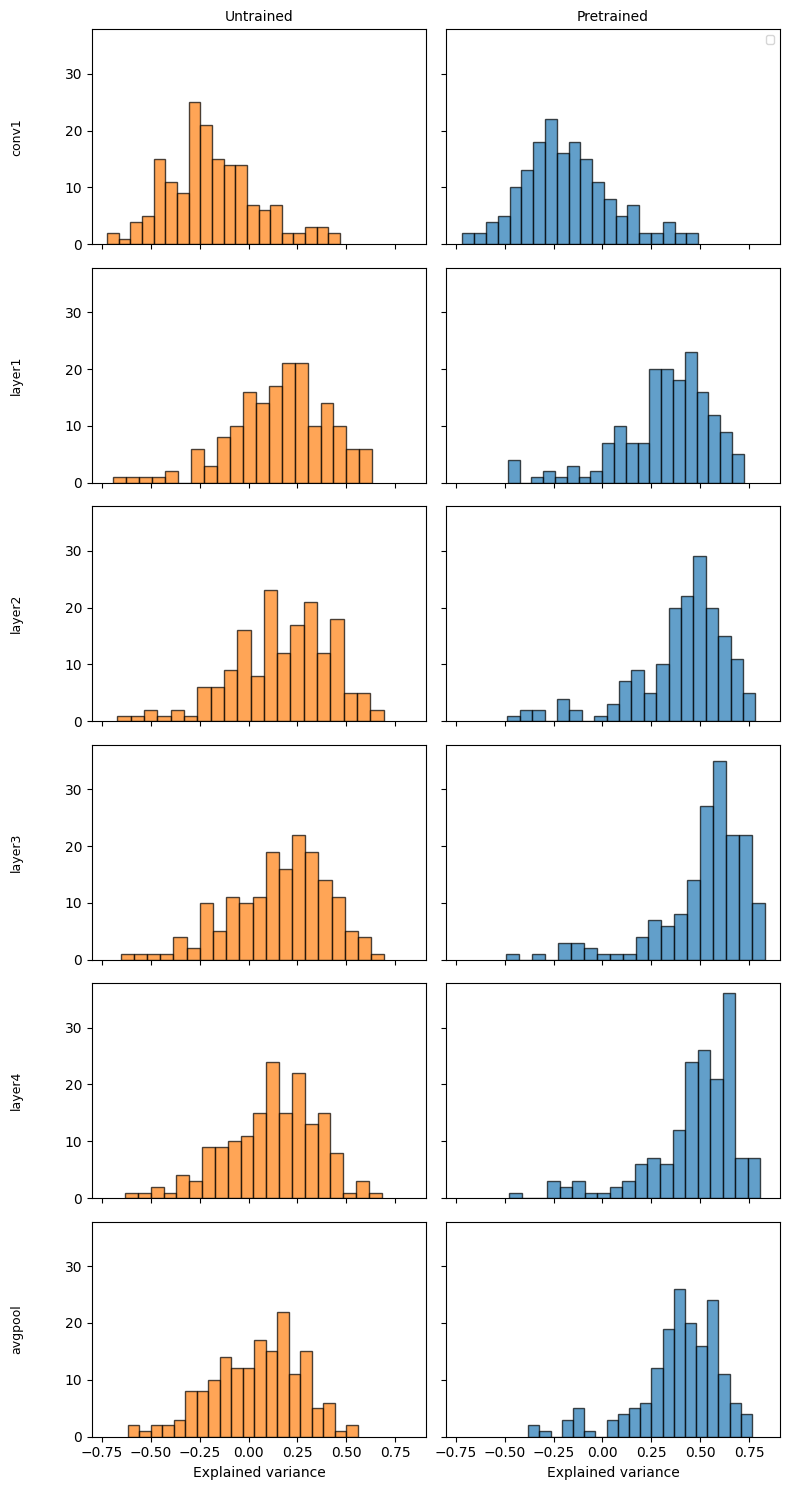

In [58]:
# Plotting
num_layers = len(layers)
fig, axes = plt.subplots(num_layers, 2, figsize=(8, 2.5 * num_layers), sharex=True, sharey=True)

for idx, layer in enumerate(layers):
    # Untrained
    data_untrained = untrained_expl_vars[layer]
    axes[idx, 0].hist(data_untrained, bins=20, edgecolor='k', alpha=0.7, color='tab:orange')
    axes[idx, 0].set_ylabel(f'{layer}', rotation=90, labelpad=30, fontsize=9)
    if idx == 0:
        axes[idx, 0].set_title('Untrained', fontsize=10)
    if idx == num_layers - 1:
        axes[idx, 0].set_xlabel('Explained variance')

    # Pretrained
    data_pretrained = pretrained_expl_vars[layer]
    axes[idx, 1].hist(data_pretrained, bins=20, edgecolor='k', alpha=0.7, color='tab:blue')
    if idx == 0:
        axes[idx, 1].set_title('Pretrained', fontsize=10)
    if idx == num_layers - 1:
        axes[idx, 1].set_xlabel('Explained variance')

# Optional: only add legend once (top-right plot)
axes[0, 1].legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig('explained_variance_comparison.png')
plt.show()

And the correlation per layer:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


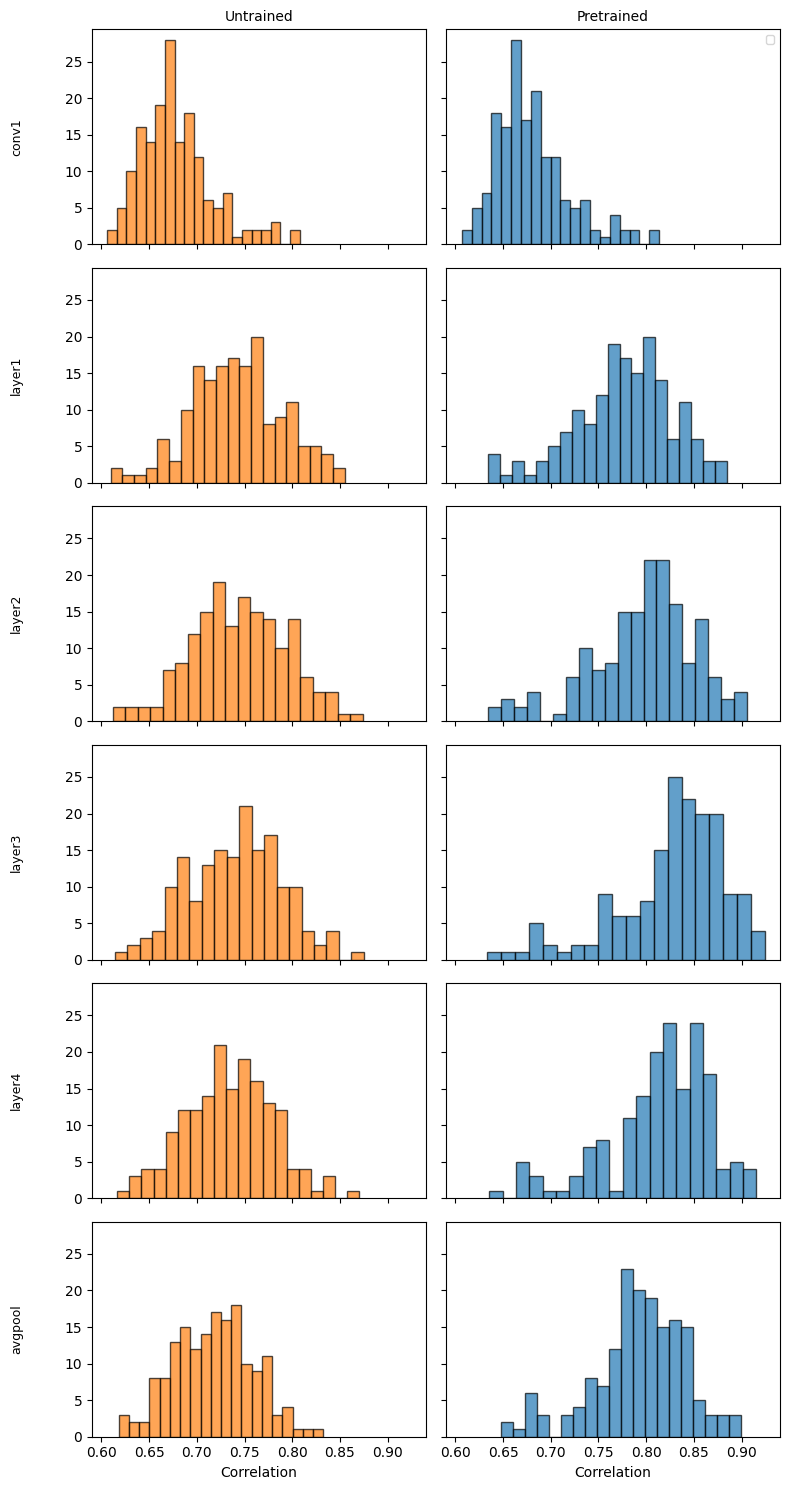

In [60]:
# Plotting
num_layers = len(layers)
fig, axes = plt.subplots(num_layers, 2, figsize=(8, 2.5 * num_layers), sharex=True, sharey=True)

for idx, layer in enumerate(layers):
    # Untrained
    data_untrained = untrained_correlations[layer]
    axes[idx, 0].hist(data_untrained, bins=20, edgecolor='k', alpha=0.7, color='tab:orange')
    axes[idx, 0].set_ylabel(f'{layer}', rotation=90, labelpad=30, fontsize=9)
    if idx == 0:
        axes[idx, 0].set_title('Untrained', fontsize=10)
    if idx == num_layers - 1:
        axes[idx, 0].set_xlabel('Correlation')
        
        
    # Pretrained
    data_pretrained = pretrained_correlations[layer]
    axes[idx, 1].hist(data_pretrained, bins=20, edgecolor='k', alpha=0.7, color='tab:blue')
    if idx == 0:
        axes[idx, 1].set_title('Pretrained', fontsize=10)
    if idx == num_layers - 1:
        axes[idx, 1].set_xlabel('Correlation')

# Optional: only add legend once (top-right plot)
axes[0, 1].legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig('correlations_comparison.png')
plt.show()

Finally, a violin plot of the explained variance:

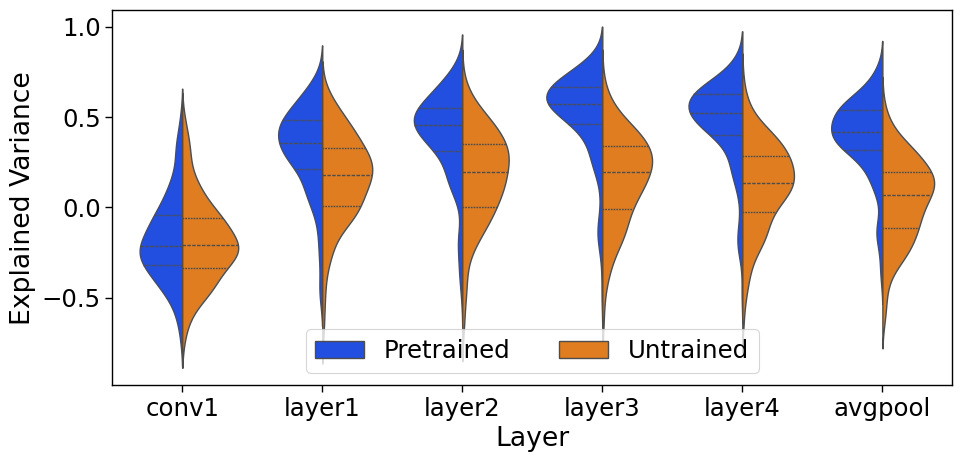

In [63]:
sns.set_context("paper", font_scale=2)

# Prepare data
data = []
for layer in layers:
    for val in pretrained_expl_vars[layer]:
        data.append({'Layer': layer, 'Explained Variance': val, 'Model': 'Pretrained'})
    for val in untrained_expl_vars[layer]:
        data.append({'Layer': layer, 'Explained Variance': val, 'Model': 'Untrained'})

df = pd.DataFrame(data)

# Violin plot
plt.figure(figsize=(10, 5))
sns.violinplot(x='Layer', y='Explained Variance', hue='Model', data=df, split=True, inner='quart', palette='bright')
plt.legend(loc='lower center', ncol=2)
# plt.title('Distribution Drift of Explained Variance per Layer')
plt.tight_layout()
plt.savefig('drift_violin_plot.png', bbox_inches='tight')
plt.show()

## Part 3: Predict the neural activity with the data-driven modeling approach

In [64]:
# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

n_out = 168
batch_size = 16
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
if not 'cuda' in device:
    print('Using CPU')

train_dataset = TensorDataset(
    torch.from_numpy(stimulus_train).float(),
    torch.from_numpy(spikes_train).float()
)

val_dataset = TensorDataset(
    torch.from_numpy(stimulus_val).float(),
    torch.from_numpy(spikes_val).float()
)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

def create_setup(optim, use_batch_norm=True):
    img_size = stimulus_train.shape[2]
    
    layers = [
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(128 * (img_size // 4) * (img_size // 4), n_out)
    ]
    if use_batch_norm:
        layers.insert(2, nn.BatchNorm2d(64))
        layers.insert(6, nn.BatchNorm2d(128))

    model = nn.Sequential(*layers)
    model = model.to(device)
    print(model)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4) if optim == 'adamw' \
        else torch.optim.SGD(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    return model, optimizer, criterion

def do_train(model, dataloader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        loss = 0.0
        mae = 0.0
        for data, targets in tqdm(dataloader, desc=f'Training - epoch {epoch+1}'):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, targets)
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            loss += loss.item()
            mae += torch.mean(torch.abs(out - targets)).item()

        loss /= len(dataloader)
        mae /= len(dataloader)
        print('Epoch [{}/{}] MSE: {:.4f}, MAE: {:.2f}'.format(epoch+1, epochs, loss, mae))
    
def do_test(model, dataloader, criterion):
    model.eval()
    loss = 0.0
    mae = 0.0
    with torch.no_grad():
        for data, targets in tqdm(dataloader, desc=f'Testing'):
            data, targets = data.to(device), targets.to(device)
            out = model(data)
            loss = criterion(out, targets)

            loss += loss.item()
            mae += torch.mean(torch.abs(out - targets)).item()

        loss /= len(dataloader)
        mae /= len(dataloader)

    return loss, mae

Using CPU


In [65]:
for optim in ['adamw', 'sgd']:
    for use_batch_norm in [True, False]:
        print(f'Optimizer: {optim}, Batch Norm: {use_batch_norm}')
        model, optimizer, criterion = create_setup(optim, use_batch_norm=use_batch_norm)
        do_train(model, trainloader, optimizer, criterion, 10)
        loss, acc = do_test(model, valloader, criterion)
        print('Final MSE: {:.4f}, MAE: {:.2f}'.format(loss, acc))
        print('--' * 20)

Optimizer: adamw, Batch Norm: True
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=401408, out_features=168, bias=True)
)


Training - epoch 1: 100%|██████████| 162/162 [01:47<00:00,  1.51it/s]


Epoch [1/10] MSE: 13.6076, MAE: 22.65


Training - epoch 2: 100%|██████████| 162/162 [01:44<00:00,  1.56it/s]


Epoch [2/10] MSE: 8.3811, MAE: 19.51


Training - epoch 3: 100%|██████████| 162/162 [01:44<00:00,  1.55it/s]


Epoch [3/10] MSE: 3.5580, MAE: 15.40


Training - epoch 4: 100%|██████████| 162/162 [01:47<00:00,  1.51it/s]


Epoch [4/10] MSE: 1.2388, MAE: 10.73


Training - epoch 5: 100%|██████████| 162/162 [01:45<00:00,  1.53it/s]


Epoch [5/10] MSE: 0.2242, MAE: 5.97


Training - epoch 6: 100%|██████████| 162/162 [01:45<00:00,  1.54it/s]


Epoch [6/10] MSE: 0.0021, MAE: 1.36


Training - epoch 7: 100%|██████████| 162/162 [01:45<00:00,  1.54it/s]


Epoch [7/10] MSE: 0.0015, MAE: 0.26


Training - epoch 8: 100%|██████████| 162/162 [01:45<00:00,  1.54it/s]


Epoch [8/10] MSE: 0.0011, MAE: 0.25


Training - epoch 9: 100%|██████████| 162/162 [01:46<00:00,  1.52it/s]


Epoch [9/10] MSE: 0.0012, MAE: 0.24


Training - epoch 10: 100%|██████████| 162/162 [01:46<00:00,  1.52it/s]


Epoch [10/10] MSE: 0.0012, MAE: 0.23


Testing: 100%|██████████| 18/18 [00:03<00:00,  4.58it/s]


Final MSE: 0.0103, MAE: 0.24
----------------------------------------
Optimizer: adamw, Batch Norm: False
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=401408, out_features=168, bias=True)
)


Training - epoch 1: 100%|██████████| 162/162 [01:38<00:00,  1.64it/s]


Epoch [1/10] MSE: 0.0018, MAE: 0.40


Training - epoch 2: 100%|██████████| 162/162 [01:36<00:00,  1.68it/s]


Epoch [2/10] MSE: 0.0016, MAE: 0.27


Training - epoch 3: 100%|██████████| 162/162 [01:39<00:00,  1.63it/s]


Epoch [3/10] MSE: 0.0018, MAE: 0.27


Training - epoch 4: 100%|██████████| 162/162 [01:39<00:00,  1.63it/s]


Epoch [4/10] MSE: 0.0016, MAE: 0.27


Training - epoch 5: 100%|██████████| 162/162 [01:38<00:00,  1.65it/s]


Epoch [5/10] MSE: 0.0015, MAE: 0.27


Training - epoch 6: 100%|██████████| 162/162 [01:39<00:00,  1.63it/s]


Epoch [6/10] MSE: 0.0017, MAE: 0.27


Training - epoch 7: 100%|██████████| 162/162 [01:38<00:00,  1.64it/s]


Epoch [7/10] MSE: 0.0019, MAE: 0.27


Training - epoch 8: 100%|██████████| 162/162 [01:37<00:00,  1.67it/s]


Epoch [8/10] MSE: 0.0015, MAE: 0.27


Training - epoch 9: 100%|██████████| 162/162 [01:38<00:00,  1.65it/s]


Epoch [9/10] MSE: 0.0016, MAE: 0.27


Training - epoch 10: 100%|██████████| 162/162 [01:37<00:00,  1.65it/s]


Epoch [10/10] MSE: 0.0019, MAE: 0.27


Testing: 100%|██████████| 18/18 [00:03<00:00,  5.08it/s]


Final MSE: 0.0146, MAE: 0.28
----------------------------------------
Optimizer: sgd, Batch Norm: True
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=401408, out_features=168, bias=True)
)


Training - epoch 1: 100%|██████████| 162/162 [01:38<00:00,  1.65it/s]


Epoch [1/10] MSE: 0.0141, MAE: 0.84


Training - epoch 2: 100%|██████████| 162/162 [01:37<00:00,  1.66it/s]


Epoch [2/10] MSE: 0.0127, MAE: 0.81


Training - epoch 3: 100%|██████████| 162/162 [01:37<00:00,  1.66it/s]


Epoch [3/10] MSE: 0.0126, MAE: 0.79


Training - epoch 4: 100%|██████████| 162/162 [01:37<00:00,  1.66it/s]


Epoch [4/10] MSE: 0.0127, MAE: 0.78


Training - epoch 5: 100%|██████████| 162/162 [01:38<00:00,  1.64it/s]


Epoch [5/10] MSE: 0.0120, MAE: 0.77


Training - epoch 6: 100%|██████████| 162/162 [01:38<00:00,  1.65it/s]


Epoch [6/10] MSE: 0.0122, MAE: 0.76


Training - epoch 7: 100%|██████████| 162/162 [01:38<00:00,  1.65it/s]


Epoch [7/10] MSE: 0.0117, MAE: 0.75


Training - epoch 8: 100%|██████████| 162/162 [01:38<00:00,  1.65it/s]


Epoch [8/10] MSE: 0.0110, MAE: 0.74


Training - epoch 9: 100%|██████████| 162/162 [01:37<00:00,  1.66it/s]


Epoch [9/10] MSE: 0.0106, MAE: 0.73


Training - epoch 10: 100%|██████████| 162/162 [01:38<00:00,  1.65it/s]


Epoch [10/10] MSE: 0.0100, MAE: 0.73


Testing: 100%|██████████| 18/18 [00:03<00:00,  4.71it/s]


Final MSE: 0.0394, MAE: 0.45
----------------------------------------
Optimizer: sgd, Batch Norm: False
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=401408, out_features=168, bias=True)
)


Training - epoch 1: 100%|██████████| 162/162 [01:27<00:00,  1.85it/s]


Epoch [1/10] MSE: 0.0017, MAE: 0.28


Training - epoch 2: 100%|██████████| 162/162 [01:28<00:00,  1.84it/s]


Epoch [2/10] MSE: 0.0016, MAE: 0.28


Training - epoch 3: 100%|██████████| 162/162 [01:27<00:00,  1.84it/s]


Epoch [3/10] MSE: 0.0018, MAE: 0.28


Training - epoch 4: 100%|██████████| 162/162 [01:27<00:00,  1.86it/s]


Epoch [4/10] MSE: 0.0018, MAE: 0.28


Training - epoch 5: 100%|██████████| 162/162 [01:28<00:00,  1.84it/s]


Epoch [5/10] MSE: 0.0015, MAE: 0.27


Training - epoch 6: 100%|██████████| 162/162 [01:29<00:00,  1.80it/s]


Epoch [6/10] MSE: 0.0016, MAE: 0.27


Training - epoch 7: 100%|██████████| 162/162 [01:28<00:00,  1.84it/s]


Epoch [7/10] MSE: 0.0017, MAE: 0.27


Training - epoch 8: 100%|██████████| 162/162 [01:28<00:00,  1.84it/s]


Epoch [8/10] MSE: 0.0015, MAE: 0.27


Training - epoch 9: 100%|██████████| 162/162 [01:28<00:00,  1.84it/s]


Epoch [9/10] MSE: 0.0014, MAE: 0.27


Training - epoch 10: 100%|██████████| 162/162 [01:27<00:00,  1.86it/s]


Epoch [10/10] MSE: 0.0015, MAE: 0.27


Testing: 100%|██████████| 18/18 [00:03<00:00,  4.96it/s]

Final MSE: 0.0130, MAE: 0.27
----------------------------------------


## Part 4: Develop the most accurate model for predicting IT neural activity

### ⚠️ **DISCLAIMER:** </br>
For this final part of the project, we organised the code into separate python scripts for better clarity and modularity. You can check it on our [GitHub repository](https://github.com/louise-montlahuc/nx414_team1) in the `src` folder. For the final submission we tried to merge everything on this notebook. </br>
You do not need to run this code, as it includes long processes like training and finetuning the models. We are just presenting our work but if you want to load the best model you can go directly to the end of the notebook.

#### 4.1: The models

In this part, our goal is to find the best model for predicting neural activity. We explore both the data-driven and the task-driven approaches and tried the following pretrained models:
- ResNet18
- ResNet50
- ResNeXt
- Vision Transformer (ViT)
- ConvNeXt
- DinoV2

These choices are inspired by the brain-score platform, where they show the highest correlation with the neural activity. The first four are more traditional models that have been widely used in the field of computer vision.

In [7]:
@MODEL_REGISTRY.register()
class ConvNeXt(IModel):
    def __init__(self):
        super(ConvNeXt, self).__init__()
        self.model = convnext_base(weights=ConvNeXt_Base_Weights.IMAGENET1K_V1)
    
    def get_layers(self, layer_name=None):
        """
        Returns the layers on which to do the linear probing.
        """    
        layer7 = self.model.get_submodule("features.7")
        classif = self.model.get_submodule("classifier")
        if layer_name == "features.7":
            return [('layer7', layer7)]
        elif layer_name == "classifier":
            return [('classifier', classif)]
        else:
            return [('layer7', layer7), ('classifier', classif)]
        
@MODEL_REGISTRY.register()
class ConvNeXt_randomW(IModel):
    def __init__(self):
        super(ConvNeXt_randomW, self).__init__()
        self.model = convnext_base(weights=None)
    
    def get_layers(self, layer_name=None):
        """
        Returns the layers on which to do the linear probing.
        """    
        layer7 = self.model.get_submodule("features.7")
        classif = self.model.get_submodule("classifier")
        if layer_name == "features.7":
            return [('layer7', layer7)]
        elif layer_name == "classifier":
            return [('classifier', classif)]
        else:
            return [('layer7', layer7), ('classifier', classif)]

In [8]:
@MODEL_REGISTRY.register()
class DinoV2(IModel):
    def __init__(self):
        super(DinoV2, self).__init__()
        self.model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
        
    def get_layers(self, layer_name=None):
        """
        Returns the layers on which to do the linear probing.
        """    
        module_block11 = self.model.get_submodule("blocks.11")
        module_norm = self.model.get_submodule("norm")
        if layer_name == "blocks.11":
            return [('block11', module_block11)]
        elif layer_name == "norm":
            return [('norm', module_norm)]
        else:
            return [('block11', module_block11), ('norm', module_norm)]

In [9]:
@MODEL_REGISTRY.register()
class ResNet18(IModel):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        
@MODEL_REGISTRY.register()
class ResNet18_randomW(IModel):
    def __init__(self):
        super(ResNet18_randomW, self).__init__()
        self.model = resnet18(weights=None)

In [10]:
@MODEL_REGISTRY.register()
class ResNet50(IModel):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

@MODEL_REGISTRY.register()    
class ResNet50_randomW(IModel):
    def __init__(self):
        super(ResNet50_randomW, self).__init__()
        self.model = resnet50(weights=None) 

In [11]:
@MODEL_REGISTRY.register()
class ResNeXt(IModel):
    def __init__(self):
        super(ResNeXt, self).__init__()
        self.model = resnext101_32x8d(weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1)
        
        
@MODEL_REGISTRY.register()
class ResNeXt_randomW(IModel):
    def __init__(self):
        super(ResNeXt_randomW, self).__init__()
        self.model = resnext101_32x8d(weights=None)

In [12]:
@MODEL_REGISTRY.register()
class ViT(IModel):
    def __init__(self):
        super(ViT, self).__init__()
        self.model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        
@MODEL_REGISTRY.register()
class ViT_randomW(IModel):
    def __init__(self):
        super(ViT_randomW, self).__init__()
        self.model = vit_b_16(weights=None)

#### 4.2: Utils functions

To set the seed:

In [13]:
def set_seed():
    seed = 0
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=True)
    return seed

To plot the results:

In [14]:
class Plotter():
    @staticmethod
    def save_corr_plot(data, title, path):
        plt.hist(data, bins=20, edgecolor='k', alpha=0.7)
        plt.xlabel('Pearson correlation coefficient')
        plt.ylabel('# neurons')
        plt.title(title)
        if not os.path.exists(os.path.dirname(path)):
            os.makedirs(os.path.dirname(path))
        plt.savefig(path)
        plt.close()
    
    @staticmethod
    def update_r2_score_csv(new_scores: dict, path: str):
        """
        Update or create a CSV file to store R² scores per model per layer.

        Args:
            model_name (str): Name of the model.
            r2_scores (dict): Mapping of layer names to R² scores.
            save_path (str): Path to the CSV file.
        """
        # Update csv if it already exists
        if os.path.exists(path):
            df = pd.read_csv(path, index_col=0)
            r2_scores = df["Score"].to_dict()
        # Create csv if it doesn't exist
        else:
            r2_scores = {}

        r2_scores.update(new_scores)

        df = pd.DataFrame(list(r2_scores.items()), columns=["Model", "Score"])
        if not os.path.exists(os.path.dirname(path)):
            os.makedirs(os.path.dirname(path))
        df.to_csv(path, index=False)

        print("Updated scores:", r2_scores)

    @staticmethod
    def save_r2_table(path_csv, path_png):
        """
        Save R² scores for models and generate a summary table image.
        
        Parameters:
            model_scores (dict): Dictionary with model names as keys and R² scores as values.
            save_path (str): File path to save the output table image.
        """
        # Use csv if it already exists
        if os.path.exists(path_csv):
            df = pd.read_csv(path_csv)
        # Create csv if it doesn't exist
        else:
            raise FileNotFoundError(f"The file '{path_csv}' was not found.")

        # Fill NaN values with 0 and round R² scores
        df["Score"] = pd.to_numeric(df["Score"], errors='coerce').fillna(0).round(4)

        # Sort by Score descending
        df = df.sort_values(by="Score", ascending=False).reset_index(drop=True)

        # Highest) R² score in bold
        best_idx = df["Score"].idxmax()
        df["Score"] = df["Score"].astype(str)  # Ensure the column is in string format
        df.loc[best_idx, "Score"] = f"$\\bf{{{df.loc[best_idx, 'Score']}}}$"  # LaTeX bold formatting

        # Arrange the name
        names = df["Model"].tolist()
        for i in range(len(names)):
            names[i] = names[i].replace("_", " ") 
            names[i] = re.sub(r'([a-zA-Z])(\d)', r'\1 \2', names[i]) # Separate letters and digits
            names[i] = re.sub(r'\b(all)\b', '', names[i], flags=re.IGNORECASE) # Remove 'all'
            names[i] = re.sub(r'\s+', ' ', names[i]).strip()
        df["Model"] = names

    
        # Plot the table
        row_height = 0.4  
        fig_height = len(df) * row_height + 1  
        fig, ax = plt.subplots(figsize=(8, fig_height))
        ax.axis('tight')
        ax.axis('off')

        table = ax.table(
            cellText=df.values,
            colLabels=df.columns,
            cellLoc='center',
            loc='center'
        )

        # Style header and model column
        header_color = "#d1e7ff"
        for (row, col), cell in table.get_celld().items():
            if row == 0:
                cell.set_facecolor(header_color)
            elif col == 0:
                cell.set_facecolor(header_color)
            cell.set_height(0.05)
            cell.set_width(0.9)
            cell.set_fontsize(12)

        plt.tight_layout()

        if not os.path.exists(os.path.dirname(path_png)):
            os.makedirs(os.path.dirname(path_png))
        plt.savefig(path_png, bbox_inches='tight')
        plt.close()

    @staticmethod
    def plot_training_history(train_losses, valid_losses, r2_scores, lrs, epochs, model_name, layer_name):
        """
        Plot the training history of the model.

        Args:
            train_losses (list): List of training losses.
            valid_losses (list): List of validation losses.
            r2_scores (list): List of R² scores.
            lrs (list): List of learning rates.
            epochs (int): Number of epochs.
            model_name (str): Name of the model.
            layer_name (str): Name of the layer.
        """
        nb_plots = 2 if len(r2_scores) == 0 else 3

        plt.figure(figsize=(6 * nb_plots, 5))

        # Plot training and validation loss
        plt.subplot(1, nb_plots, 1)
        plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue')
        plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss', color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'{model_name} - Training and Validation Loss')
        plt.legend()

        # Plot learning rate
        plt.subplot(1, nb_plots, 2)
        plt.plot(range(1, epochs + 1), lrs, label='Learning Rate', color='green')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.title(f'{model_name} - Learning Rate Schedule')
        plt.legend()

        if len(r2_scores) > 0:
            # Plot R² scores
            plt.subplot(1, 3, 3)
            plt.plot(range(1, epochs + 1), r2_scores, label=r'$R^2$', color='green')
            plt.xlabel('Epochs')
            plt.ylabel(r'$R^2$')
            plt.title(f'{model_name} - R² Score')
            plt.legend()

        if not os.path.exists(os.path.dirname('./saved/plots/')):
            os.makedirs(os.path.dirname('./saved/plots/'))
        
        plt.savefig(f'./saved/plots/{model_name}_{layer_name}_training_history_{epochs}ep.png')
        plt.close()

To visualize an image given the corresponding stimulus:

In [15]:
def visualize_img(stimulus,objects,stim_idx):
    """Visualize image given the stimulus and corresponding index and the object name.

    Args:
        stimulus (array of float): Stimulus containing all the images
        objects (list of str): Object list containing all the names
        stim_idx (int): Index of the stimulus to plot
    """    
    normalize_mean=[0.485, 0.456, 0.406]
    normalize_std=[0.229, 0.224, 0.225]

    img_tmp = np.transpose(stimulus[stim_idx],[1,2,0])

    ### Go back from normalization
    img_tmp = (img_tmp*normalize_std + normalize_mean) * 255

    plt.figure()
    plt.imshow(img_tmp.astype(np.uint8),cmap='gray')
    plt.title(str(objects[stim_idx]))
    plt.show()
    return

#### 4.3: Tools functions

To load the data:

In [16]:
def get_data():
    """Get the data from the IT dataset.

    Returns:
        tuple: tuples (stimulus, objects, spikes) for training and validation sets.
    """
    stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data('./data/')
    return (stimulus_train, objects_train, spikes_train), (stimulus_val, objects_val, spikes_val)

def make_dataloader(batch_size, driven='data'):
    """Create a PyTorch data loader, depending on whether the model is data-driven or
    task-driven.

    Args:
        batch_size (int): Batch size for the data loader.
        driven (str, optional): 'data' if the model is data-driven, 'task' if the model is
        task-driven. Defaults to 'data'.
    """
    train_data, val_data = get_data()
    if driven == 'task':
        train_dataset = ITDataSet(train_data[0], train_data[1])
        val_dataset = ITDataSet(val_data[0], val_data[1])
        num_classes = len(set(train_data[1]))
    elif driven == 'data':
        train_dataset = TensorDataset(
            torch.from_numpy(train_data[0]).float(),
            torch.from_numpy(train_data[2]).float()
        )

        val_dataset = TensorDataset(
            torch.from_numpy(val_data[0]).float(),
            torch.from_numpy(val_data[2]).float()
        )
        num_classes = 168 # one output per neuron
    else:
        raise ValueError("driven must be either 'task' or 'data'")
    
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return trainloader, valloader, num_classes

class ITDataSet(Dataset):
    def __init__(self, images, labels):
        super().__init__()
        self.images = torch.from_numpy(images).float()
        label_encoder = LabelEncoder()
        encoded_labels = label_encoder.fit_transform(labels)
        self.labels = encoded_labels

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        return image, label

To fit different regression models to the activations of the models:

In [17]:
def fit(x, y, method, seed):
    """Fits a regression model to the activations of the model.

    Args:
        x (np.ndarray): the input data to the model.
        y (np.ndarray): the target variable to fit the regression model to.
        method (str): which method to use for the regression model.
            'linear' for linear regression, 'ridge' for ridge regression, and 'mlp' for MLP.

    Raises:
        ValueError: if the method is not supported.

    Returns:
        model: the fitted regression model, that possess the method `predict`.
    """
    if method == 'linear':
        return _fit_linear_regression(x, y)
    elif method == 'ridge':
        return _fit_ridge_regression(x, y, seed)
    elif method == 'mlp':
        return _fit_mlp_regression(x, y, seed)
    else:
        raise ValueError(f"Unknown method: {method}. Supported methods are 'linear', 'ridge', and 'mlp'.")

def _fit_linear_regression(x, y):
    """
    Fits a linear regression model to the activations of the model.
    Args:
        x (np.ndarray): the input data to the model.
        y (np.ndarray): the target variable to fit the regression model to.
    Returns:
        model: the fitted regression model, that possess the method `predict`.
    """
    linreg = LinearRegression() 
    linreg.fit(x, y)
    return linreg
        
def _fit_ridge_regression(x, y, seed):
    """
    Fits a ridge regression model to the activations of the model.
    Args:
        x (np.ndarray): the input data to the model.
        y (np.ndarray): the target variable to fit the regression model to.
    Returns:
        model: the fitted regression model, that possess the method `predict`.
    """
    ridge = Ridge(random_state=seed)
    ridge.fit(x, y)
    return ridge

def _fit_mlp_regression(x, y, seed): # TODO MLP does not work at all, find out why
    """
    Trains an MLP to fit the activations of the model.
    Args:
        x (np.ndarray): the input data to the model.
        y (np.ndarray): the target variable to fit the regression MLP to.
    Returns:
        model: the fitted regression model, that possess the method `predict`.
        scaler: the scaler used to scale the input data.
    """
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=200, early_stopping=True, verbose=True, random_state=seed) # max_iter is the number of epochs
    mlp.fit(x_scaled, y)
    return mlp, scaler

To select the optimizer:

In [18]:
def make_optimizer(name, model, lr, weight_decay):
    """Create an optimizer for the model.
    Args:
        name (str): name of the optimizer.
        model (torch.nn.Module): model to optimize.
        lr (float): learning rate.
        weight_decay (float): weight decay.
    """
    classif_params = list(model.fc.parameters())
    all_params = list(model.parameters())
    classif_param_ids = set(id(p) for p in classif_params)
    base_params = [p for p in all_params if id(p) not in classif_param_ids]

    if name == 'adamw':
        return torch.optim.AdamW([
            {'params': base_params, 'lr': 0.1 * lr},
            {'params': classif_params, 'lr': lr}
        ], weight_decay=weight_decay)
    elif name == 'sgd':
        return torch.optim.SGD([
            {'params': base_params, 'lr': 0.1 * lr},
            {'params': classif_params, 'lr': lr}
        ], weight_decay=weight_decay)
    else:
        raise NotImplementedError(f"Optimizer {name} is not implemented.") 

To make a learning rate scheduler for the optimizer:

In [19]:
def make_scheduler(optimizer, warmup_epochs, args, train_loader):
    """
    Creates a learning rate scheduler for the optimizer.
    Args:
        optimizer: The optimizer you're using.
        warmup_epochs: Number of epochs for the warmup phase.
        args: Arguments, must include total epochs `args.epochs`.
        train_loader: The DataLoader for the training set (to determine steps per epoch).
    """
    steps_per_epoch = len(train_loader)
    warmup_steps = warmup_epochs * steps_per_epoch
    warmup_scheduler = LambdaLR(optimizer, lr_lambda=lambda step: step / warmup_steps if step < warmup_steps else 1.0)
    total_steps = steps_per_epoch * args.epochs
    cosine_scheduler = CosineAnnealingLR(optimizer, T_max=total_steps - warmup_steps, eta_min=0)
    lr_scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_steps])
    return lr_scheduler

To finetune the models:

In [20]:
def finetune(model, args):
    """Finetune the model on the IT dataset (data-driven or task-driven).
    Args:
        model (torch.nn.Module): model to finetune.
        args (argparse.Namespace): arguments.
    """
    trainloader, valloader, num_classes = make_dataloader(16, args.driven)
    # Cut and set head after specific layer
    model = model.change_head(args.layer, num_classes)
    print(model)
    optim = make_optimizer(args.optimizer, model, args.lr, 1e-5)
    scheduler = make_scheduler(optim, 4, args, trainloader)

    device = torch.device("cpu")
    if torch.cuda.is_available():
        device = torch.device("cuda")
        model = model.to(device)

    if args.driven == 'task':
        # Finetunes the model by object (image) classification
        criterion = nn.CrossEntropyLoss()
        do_train(model, trainloader, valloader, optim, criterion, scheduler, args.epochs, device, args)
    elif args.driven == 'data':
        # Finetunes the model by data (neural) regression
        criterion = nn.MSELoss()
        do_train(model, trainloader, valloader, optim, criterion, scheduler, args.epochs, device, args)
    else:
        raise ValueError(f"Unknown driven argument: {args.driven}. Supported methods are 'task' and 'data'.")
    
    return model

def do_train(model, train_loader, val_loader, optim, criterion, scheduler, epochs, device, args):
    """Train the model.
    Args:
        model (torch.nn.Module): model to train.
        train_loader (torch.utils.data.DataLoader): training data loader.
        val_loader (torch.utils.data.DataLoader): validation data loader.
        optim (torch.optim.Optimizer): optimizer for the model.
        criterion (torch.nn.Module): loss function.
        scheduler (torch.optim.lr_scheduler._LRScheduler): learning rate scheduler.
        epochs (int): number of epochs to train the model.
        device (torch.device): device to use for training.
        args (argparse.Namespace): arguments.
    """
    train_losses = []
    valid_losses = []
    lrs = []
    r2s = []

    best_valid_loss = float('inf')
    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss = 0.

        for data, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} - Training'):
            data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)

            optim.zero_grad()
            out = model(data)
            loss = criterion(out, targets)

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
            optim.step()
            scheduler.step()

            train_loss += loss.item() * data.size(0)

        train_loss /= len(train_loader.dataset)
        print(f'Train Loss: {train_loss:.4f}')
       
        # ---- Validation ----
        model.eval()
        valid_loss = 0.
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for data, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} - Validation'):
                data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                out = model(data)

                loss = criterion(out, targets)
                valid_loss += loss.item() * data.size(0)

                all_preds.append(out.cpu())
                all_targets.append(targets.cpu())

        valid_loss /= len(val_loader.dataset)

        if args.driven == 'data':
            # Stack all batches to compute R2
            all_preds = torch.cat(all_preds).numpy()
            all_targets = torch.cat(all_targets).numpy()
            r2 = r2_score(all_targets, all_preds)
            r2s.append(r2)

        print(f'Validation Loss: {valid_loss:.4f}{f"| R^2 score: {r2:.4f}" if args.driven == "data" else ""}')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'saved/models/{args.name}_best_model.pth')
            print(f'Saved best model with validation loss: {best_valid_loss:.4f}')

        # ---- Logging ----
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        lrs.append(scheduler.get_last_lr()[0])
        print(f'Learning Rate: {scheduler.get_last_lr()[0]:.10f}')

    # Plot the training history
    Plotter.plot_training_history(train_losses, valid_losses, r2s, lrs, epochs, args.name, args.layer)

To probe the models:

In [ ]:
def score(model, layer_name, args):
    """
    Score for a data-driven finetuned model.
    Args:
        model (IModel): the model.
        layer_name (str): name of the layer where the model has been cut.
        args (argparse.Namespace): arguments.
    """
    with torch.no_grad():
        _, val_data = get_data()
        stimulus_val, _, spikes_val = val_data
        stimulus_val = torch.from_numpy(stimulus_val)
        spikes_val = torch.from_numpy(spikes_val)

        print('Computing activations...')
        out = model(stimulus_val)

        _compute_score(spikes_val, out, layer_name, args)
        print('DONE!')

def linprob(model, seed, args):
    """Linear probing of the model.

    Args:
        model (IModel): the model.
        args (argparse.Namespace): arguments.
    """
    if args.driven == 'data' and args.finetune:
        _linprob_finetuned(model, seed, args)
    else:
        _linprob(model, seed, args)

def _linprob_finetuned(model, seed, args):
    """
    In this case, the finetuning is done after a given layer (in args). We thus need to probe
    only the previous to last layer (last is MLP).
    """
    model.eval()
    with torch.no_grad():
        train_data, val_data = get_data()
        stimulus_train, _, spikes_train = train_data
        stimulus_train = torch.from_numpy(stimulus_train)
        spikes_train = torch.from_numpy(spikes_train)
        stimulus_val, _, spikes_val = val_data
        stimulus_val = torch.from_numpy(stimulus_val)
        spikes_val = torch.from_numpy(spikes_val)

        print('Registering hooks...')
        handles = model.register_hook(args.hook, args.finetune, args.layer)
        
        print('Computing activations...')
        model(stimulus_train)
        activations = model.get_activations(args.hook)

        print('\tLayer:', args.layer)
        regression = fit(activations, spikes_train, method=args.probing, seed=seed)

        # Test the regression on the validation set
        print('Testing the regression...')
        model.reset_activations()

        model(stimulus_val)
        activations = model.get_activations(args.hook)

        ## Remove handles
        for handle in handles:
            handle.remove()
        
        print('\tLayer:', args.layer)
        if isinstance(regression, tuple): # MLP returns both the model and the scaler
            regression, scaler = regression
            activations = scaler.transform(activations)
        pred_activity = regression.predict(activations)
        _compute_score(spikes_val, pred_activity, args.layer, args)
        print('Done!')

def _linprob(model, seed, args):
    model.eval()
    layer_regressions = dict()
    save_folder = os.path.join(os.getcwd(), 'saved')

    with torch.no_grad():
        train_data, val_data = get_data()
        stimulus_train, _, spikes_train = train_data
        stimulus_train = torch.from_numpy(stimulus_train)
        spikes_train = torch.from_numpy(spikes_train)
        stimulus_val, _, spikes_val = val_data
        stimulus_val = torch.from_numpy(stimulus_val)
        spikes_val = torch.from_numpy(spikes_val)

        print('Registering hooks...')
        handles = model.register_hook(args.hook, args.finetune, args.layer)
        
        # Fit the regression on the activations of the training set
        print('Computing activations...')
        save_folder = os.path.join(os.getcwd(), 'saved')
        if args.saved and os.path.exists(f'{save_folder}/activations/{args.name}_{args.hook}_train_activations.pt'):
            print('Loading saved training activations...')
            activations = torch.load(f'{save_folder}/activations/{args.name}_{args.hook}_train_activations.pt', weights_only=False)
        else:
            model(stimulus_train)
            activations = model.get_activations(args.hook)
            torch.save(activations, f'{save_folder}/activations/{args.name}_{args.hook}_train_activations.pt')

        print('Fitting the regressions...')
        layers = model.get_layers(args.layer) if args.finetune else model.get_layers()
        for layer_name, _ in layers:
            print('\tLayer:', layer_name)
            layer_regressions[layer_name] = fit(activations[layer_name], spikes_train, method=args.probing, seed=seed)

        # Test the regression on the validation set
        print('Testing the regression...')
        model.reset_activations()

        if args.saved and os.path.exists(f'{save_folder}/activations/{args.name}_{args.hook}_valid_activations.pt'):
            print('Loading saved validation activations...')
            activations = torch.load(f'{save_folder}/activations/{args.name}_{args.hook}_valid_activations.pt', weights_only=False)
        else:
            model(stimulus_val)
            activations = model.get_activations(args.hook)
            torch.save(activations, f'{save_folder}/activations/{args.name}_{args.hook}_valid_activations.pt')

        ## Remove handles
        for handle in handles:
            handle.remove()
        
        for layer_name, regr in layer_regressions.items():
            print('\tLayer:', layer_name)
            if isinstance(regr, tuple): # MLP returns both the model and the scaler
                regr, scaler = regr
                activations[layer_name] = scaler.transform(activations[layer_name])
            pred_activity = regr.predict(activations[layer_name])
            _compute_score(spikes_val, pred_activity, layer_name, args)
        print('Done!')

def _compute_score(y_true, y_pred, layer_name, args):
    save_folder = os.path.join(os.getcwd(), 'saved')
    correlations = []
    for i in range(y_true.shape[1]):
        corr, _ = pearsonr(y_pred[:, i], y_true[:, i])
        correlations.append(corr)

    # Compute mean R² score
    r2 = r2_score(y_true, y_pred)
    name = f'{args.name}_{"finetuned" if args.finetune else "pretrained"}_{layer_name}{f"_{args.probing}" if not args.finetune else ""}_{args.hook}'
    new_score = {name: r2}
    Plotter.update_r2_score_csv(new_score, f"{save_folder}/r2_scores.csv")
    Plotter.save_r2_table(
        path_csv=f"{save_folder}/r2_scores.csv",
        path_png=f"{save_folder}/r2_scores.png"
    )

    Plotter.save_corr_plot(
        data=correlations,
        title=f'[{args.name}/{args.probing if not args.finetune else "finetuned"}/{args.hook}]\nCorrelation between predicted and actual spikes for layer {layer_name}',
        path=f'{save_folder}/figures/corr_{args.name}_{"finetuned" if args.finetune else "pretrained"}_{layer_name}{f"_{args.probing}" if not args.finetune else ""}_{args.hook}_.png'
    )

#### 4.4: Main python cell to use the rest of the code

In [35]:
# Set the Parameters

class args():
    """
    Abstract base class for the parameters.
    
    Args:
        name: Model name (str)
        Models available:
        Simple
        - `lin_reg`
        - `ridge_reg`
        - `mlp_reg`
        Pretrained
        - `ResNet18`
        - `ResNet50`
        - `ResNeXt`
        - `ConvNeXt`
        - `ViT`
        - `DinoV2`
        finetune: Whether to finetune the model or use as is
        driven: Data- or task-driven finetuning (str)
            - `data`: data-driven modeling approach
            - `task`: task-driven modeling approach
        hook: Hook name (str)
        probing: Probing method (only for task-driven) (str)
            - `linear`: linear regression probing
            - `ridge`: Ridge regression probing
            - `mlp`: MLP regression probing
        layer: Layer name (only for finetuning) (str)
            For the pretrained models, the layers to test are automatically selected.
        optimizer: Optimizer name (str)
            - `adamw`: AdamW optimizer
             - `sgd`: Stochastic Gradient Descent
        lr: Learning rate for finetuning (float)
        epochs: Number of epochs for finetuning (int)
        saved: Use saved activations, if any. Default is to not use them. 
    
    """
    def __init__(self, name_='ResNet18', finetune_=False, driven_='data', hook_='all', probing_='linear', layer_='layer3', optimizer_='adamw', lr_=1e-5, epochs_=30, saved_=False):
        self.name = name_
        self.finetune = finetune_
        self.driven = driven_
        self.hook = hook_
        self.probing= probing_
        self.layer=layer_
        self.optimizer=optimizer_
        self.lr=lr_
        self.epochs=epochs_
        self.saved=saved_

If you want to play around with our methods (finetune a model, probe it, change the head, ...), you can do so with the following main method. However, we don't recommand trying that on the Jupyter notebook, it is likely the kernel will crash due to the limitations of this format.

In [52]:
def main(args):
    seed = set_seed()
    download_data('./data/') # Download the data if not already done
    model = make_model(args.name, seed)
    if args.finetune:
        model = finetune(model, args)
        model.load_state_dict(torch.load(f'./saved/models/{args.name}_best_model.pth'))
        model.to('cpu') # Make sure the model is back on CPU
    else:
        print(model)

    if not args.finetune or args.driven == 'task':
        linprob(model, seed, args)
    else:
        # No need to do probing, just pass through the model
        score(model, args.layer, args)

parameters = args(name_='ResNeXt', finetune_=True, driven_='data', hook_='all', probing_='linear', layer_='layer3', optimizer_='adamw', lr_=1e-5, epochs_=30, saved_=False)
#main(parameters)

## Loading the best model

Our best $R^2$ score was obtained by finetuning in a data-driven way a pretrained ResNeXt model.

In [66]:
seed = set_seed()
model = make_model('ResNeXt', seed)
model = model.change_head('layer3', 168)
model.to('cpu')
print('Model prepared...')

Model prepared...


We can now load our saved weights (https://drive.google.com/file/d/12apWfWDgrv2yiqbcZ0jHm8yYWdOX94ze/view?usp=sharing):

In [ ]:
weights = torch.load('best_model.pth', map_location='cpu')
model.load_state_dict(weights)

## Inference time!

Let's try our model on the validation data and check the $R^2$ score we obtain.

In [55]:
score(model, 'layer3', parameters)

Computing activations...
Updated scores: {'ResNet18_finetuned_layer3_all': 0.3485784341161019, 'ResNeXt_finetuned_layer3_all': 0.3485784341161019}
DONE!
